# Generate a lens using _MuSLIT_ & _pyLensModels_

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import scipy.signal as scp

from MuSLIT.lensing import planes
from MuSLIT.utils.image import square_grid
from MuSLIT.utils.plot import nice_colorbar

from pylensmodels.mass.spemd import SPEMD_glee

%matplotlib inline

### Source setup

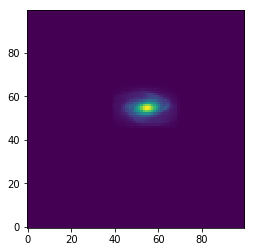

In [2]:
# Source light profile
source_path = "../Data/various_images/M81_HST_prepared_n100.fits"
source = pf.open(source_path)[0].data
source *= 10 # increase the flux, for comparison with lenstronomy sim

plt.imshow(source, origin='lower')
plt.show()

### PSF setup

(73, 73)


/Users/aymericg/anaconda2/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


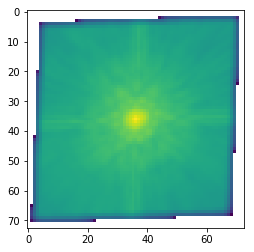

In [3]:
# N1,N2 are the numbers of pixels in the image plane.
num_pix = 100

# Size ratio of the source to image number of pixels 
size = 1

#PSF
PSF0 = pf.open('../Data/SLIT_images/PSF.fits')[0].data
PSF = PSF0[1:,1:]
PSFconj = np.real(np.fft.ifft2(np.conjugate(np.fft.fft2(PSF0[:-1,:-1]))))
PSFconj = PSFconj/np.sum(PSFconj)
PSF = PSF/np.sum(PSF)
print(PSF.shape)

plt.imshow(np.log10(PSF))

In [4]:
# Compute the convergence kappa
x_grid, y_grid = square_grid(num_pix)

kwargs_spemd = {
    'x0': 50.5,  # pixels (origin : lower left pixel)
    'y0': 50.5,  # pixels (origin : lower left pixel)
    'gamma': 0.5,
    'theta_E': 20.,  # pixels
    'q': 0.5,
    'phi': np.pi/8,
    'r_core': 0.00000001,  # pixels
}

# WARNING : no Dds/Ds scaling
mass_model = SPEMD_glee(kwargs_spemd, Dds_Ds=None)
alpha1, alpha2 = mass_model.deflection(x_grid, y_grid)

In [5]:
extra_num_pix = 1000
x_grid_large, y_grid_large = square_grid(extra_num_pix)
kwargs_spemd_large = copy.deepcopy(kwargs_spemd)
kwargs_spemd_large['x0'] = kwargs_spemd['x0'] + extra_num_pix/2
kwargs_spemd_large['y0'] = kwargs_spemd['y0'] + extra_num_pix/2

mass_model_large = SPEMD_glee(kwargs_spemd_large, Dds_Ds=None)
kappa_extended = mass_model_large.convergence(x_grid_large, y_grid_large)

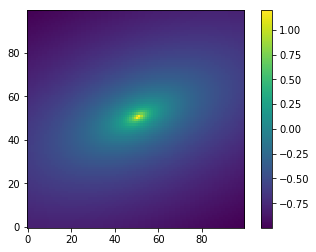

In [6]:
x0_ext = kwargs_spemd_large['x0']
y0_ext = kwargs_spemd_large['y0']
kappa = kappa_extended[int(x0_ext-num_pix/2):int(x0_ext+num_pix/2), int(y0_ext-num_pix/2):int(y0_ext+num_pix/2)]

plt.imshow(np.log10(kappa), origin='lower')
plt.colorbar()
plt.show()

In [7]:
# Mapping between lens and source IMPORTANT
#lensing_op = planes.build_lensing_operator(kappa_extended, num_pix, size)
lensing_op = planes.build_lensing_operator(None, num_pix, size, alpha_x_in=alpha1, alpha_y_in=alpha2)

Deflection angles have been provided


In [8]:
# Generation of lensed source
I2 = planes.source_to_image(source, lensing_op, num_pix)

# Convolution by the PSF and generation of the final image
image_no_noise = scp.fftconvolve(I2, PSF, mode='same')

# Noise levels
SNR = 100
sigma = np.sqrt(np.sum(I2**2)/SNR/(num_pix*size)**2)
noise = np.random.randn(num_pix, num_pix)*sigma

# Final simulated image
image_sim = image_no_noise + noise

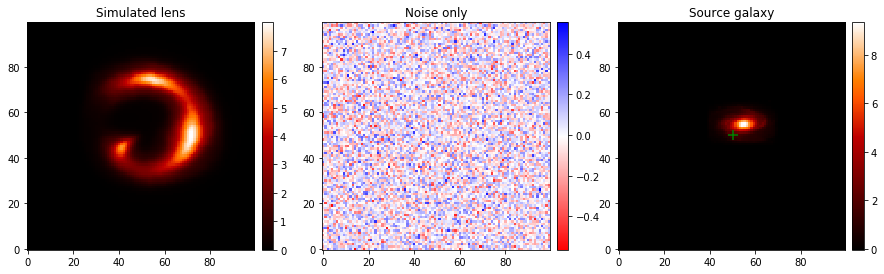

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes[0]
ax.set_title("Simulated lens")
im = ax.imshow(image_no_noise, origin='lower', cmap='gist_heat')
nice_colorbar(im)

ax = axes[1]
ax.set_title("Noise only")
im = ax.imshow(image_sim-image_no_noise, origin='lower', cmap='bwr_r') #, vmin=-0.1, vmax=0.1)
nice_colorbar(im)

ax = axes[2]
ax.set_title("Source galaxy")
im = ax.imshow((source), origin='lower', cmap='gist_heat')
ax.scatter(num_pix/2., num_pix/2., color='green', marker='+', s=120) # center of the image
nice_colorbar(im)

plt.show()